# Adjust the JC baseline level

In this notebook we adjust the Jena Carboscope derived APO baseline to match the level of the observations

For this process we assume that ocean contributions to the osbervations are negligible. 

- We then model APO, excluding any ocean contribution, and take the top 10 percentile of points.
- We find the difference between these and observational data at the same time points.
- Then we adjust the JC baseline by the average of this difference.

In [1]:
import os, glob
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs
from acrg.config.paths import Paths

import apo_emiss_func, apo_filter, apo_plot_info, apo_funcs

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
year = 2021
months = [mm for mm in range(1, 13)]
sites = ['WAO', 'HFD'] #, 'RGL'
ocean_sims = ['ECCO', 'Jena', 'NEMO']


months = [months] if type(months)==int else months

start_dates = {month: datetime(year, month, 1) for month in months}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}

nrows = len(months) * len(sites)

sites = {site: code for site, code in apo_plot_info.sitecodes.items() if site in sites}

date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
           f'{year}{str(months[0]).zfill(2)}-{year}{str(months[-1]).zfill(2)}' if len(months)==2 else \
           f'{year}{str(months[0]).zfill(2)}'

print(f'Date string for filename: {date_str}')

Date string for filename: 2021


## Make the APO model

- import the timeseries for each component,
- split into months,
- combine into an APO model, with no ocean component.

In [3]:
ts_data_year = apo_funcs.get_timeseries(sites=sites.keys(), year=year, sources=['ff', 'ocean', 'bc'])

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2021.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2021.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2021.nc']


/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libLerc.so.4: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 
['co2_ff', 'o2_ff', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'co2_ocean_nemo', 'o2_ocean_nemo', 'n2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc']
---------------------------

Finding timeseries for HFD
ff: ['/user/work/vf20487/Timeseries/o2_co2/HFD_ff_timeseries_2021.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/HFD_ocean_timeseries_2021.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/HFD_bc_timeseries_2021.nc']

Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 
['co2_ff', 'o2_ff', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'co2_ocean_nemo', 'o2_ocean_nemo', 'n2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc']
---------------------------



In [4]:
ts_data_all = {site: {month: ts_site.sel(time=slice(start, end_dates[month]))
                      for month, start in start_dates.items()}
               for site, ts_site in ts_data_year.items()}

In [5]:
apo_model_no_ocean = {site: {month: apo_emiss_func.apo(ocean_co2 = xr.zeros_like(ts_month.o2_ocean_nemo),
                                                       ocean_n2 = xr.zeros_like(ts_month.o2_ocean_nemo),
                                                       ocean_o2 = xr.zeros_like(ts_month.o2_ocean_nemo),
                                                       ff_co2 = ts_month.co2_ff,
                                                       ff_o2 = ts_month.o2_ff) + ts_month.apo_bc
                             for month, ts_month in ts_site.items()}
                      for site, ts_site in ts_data_all.items()}

## Get the observations

- get the obs for each site for the whole year,
- split into months.

In [30]:
apo_obs_year = get_obs(list(sites.keys()), 'APO', f'{year}-01-01', f'{year+1}-01-01', keep_missing=True)
if 'HFD' in sites.keys() and year>=2021:
    if len(apo_obs_year['HFD'])==0:
        fname_hfd = glob.glob(os.path.join('/group', 'chemistry', 'acrg', 'obs', 'HFD', f'UEA-Oxzilla_HFD_2021*APO*.nc'))[0]
        apo_obs_year['HFD'] = name.open_ds(fname_hfd)
        apo_obs_year['HFD']['mf'] = apo_obs_year['HFD'].apo.sel(time=slice( f'{year}-01-01', f'{year+1}-01-01'))
        apo_obs_year['HFD'] = [apo_obs_year['HFD']]
apo_obs = {month: {site: apo_site[0].sel(time=slice(start, end_dates[month])) if len(apo_site)>0 else []
                   for site, apo_site in apo_obs_year.items()}
           for month, start in start_dates.items()}

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20210101_APO-20221215.nc
... slicing from 2021-01-01 00:00:00 to 2021-12-31 23:59:59.999999999
Getting APO data for HFD...


## Estimate the difference

- find the top 10 percentile of the no-ocean APO model,
- find the corresponding observations,
- find the difference between the points at each timestep,
- find the average difference.

In [15]:
percentile = 80

model_bkg_points = {site: {month: apo_month[apo_month>np.nanpercentile(apo_month, percentile)]
                           for month, apo_month in apo_site.items()}
                    for site, apo_site in apo_model_no_ocean.items()}

obs_bkg_points = {site: {month: apo_obs[month][site].mf[apo_month>np.nanpercentile(apo_month, percentile)]
                                if len(apo_obs[month][site].mf.dropna(dim='time'))>0 else None
                         for month, apo_month in apo_site.items()}
                  for site, apo_site in apo_model_no_ocean.items()}

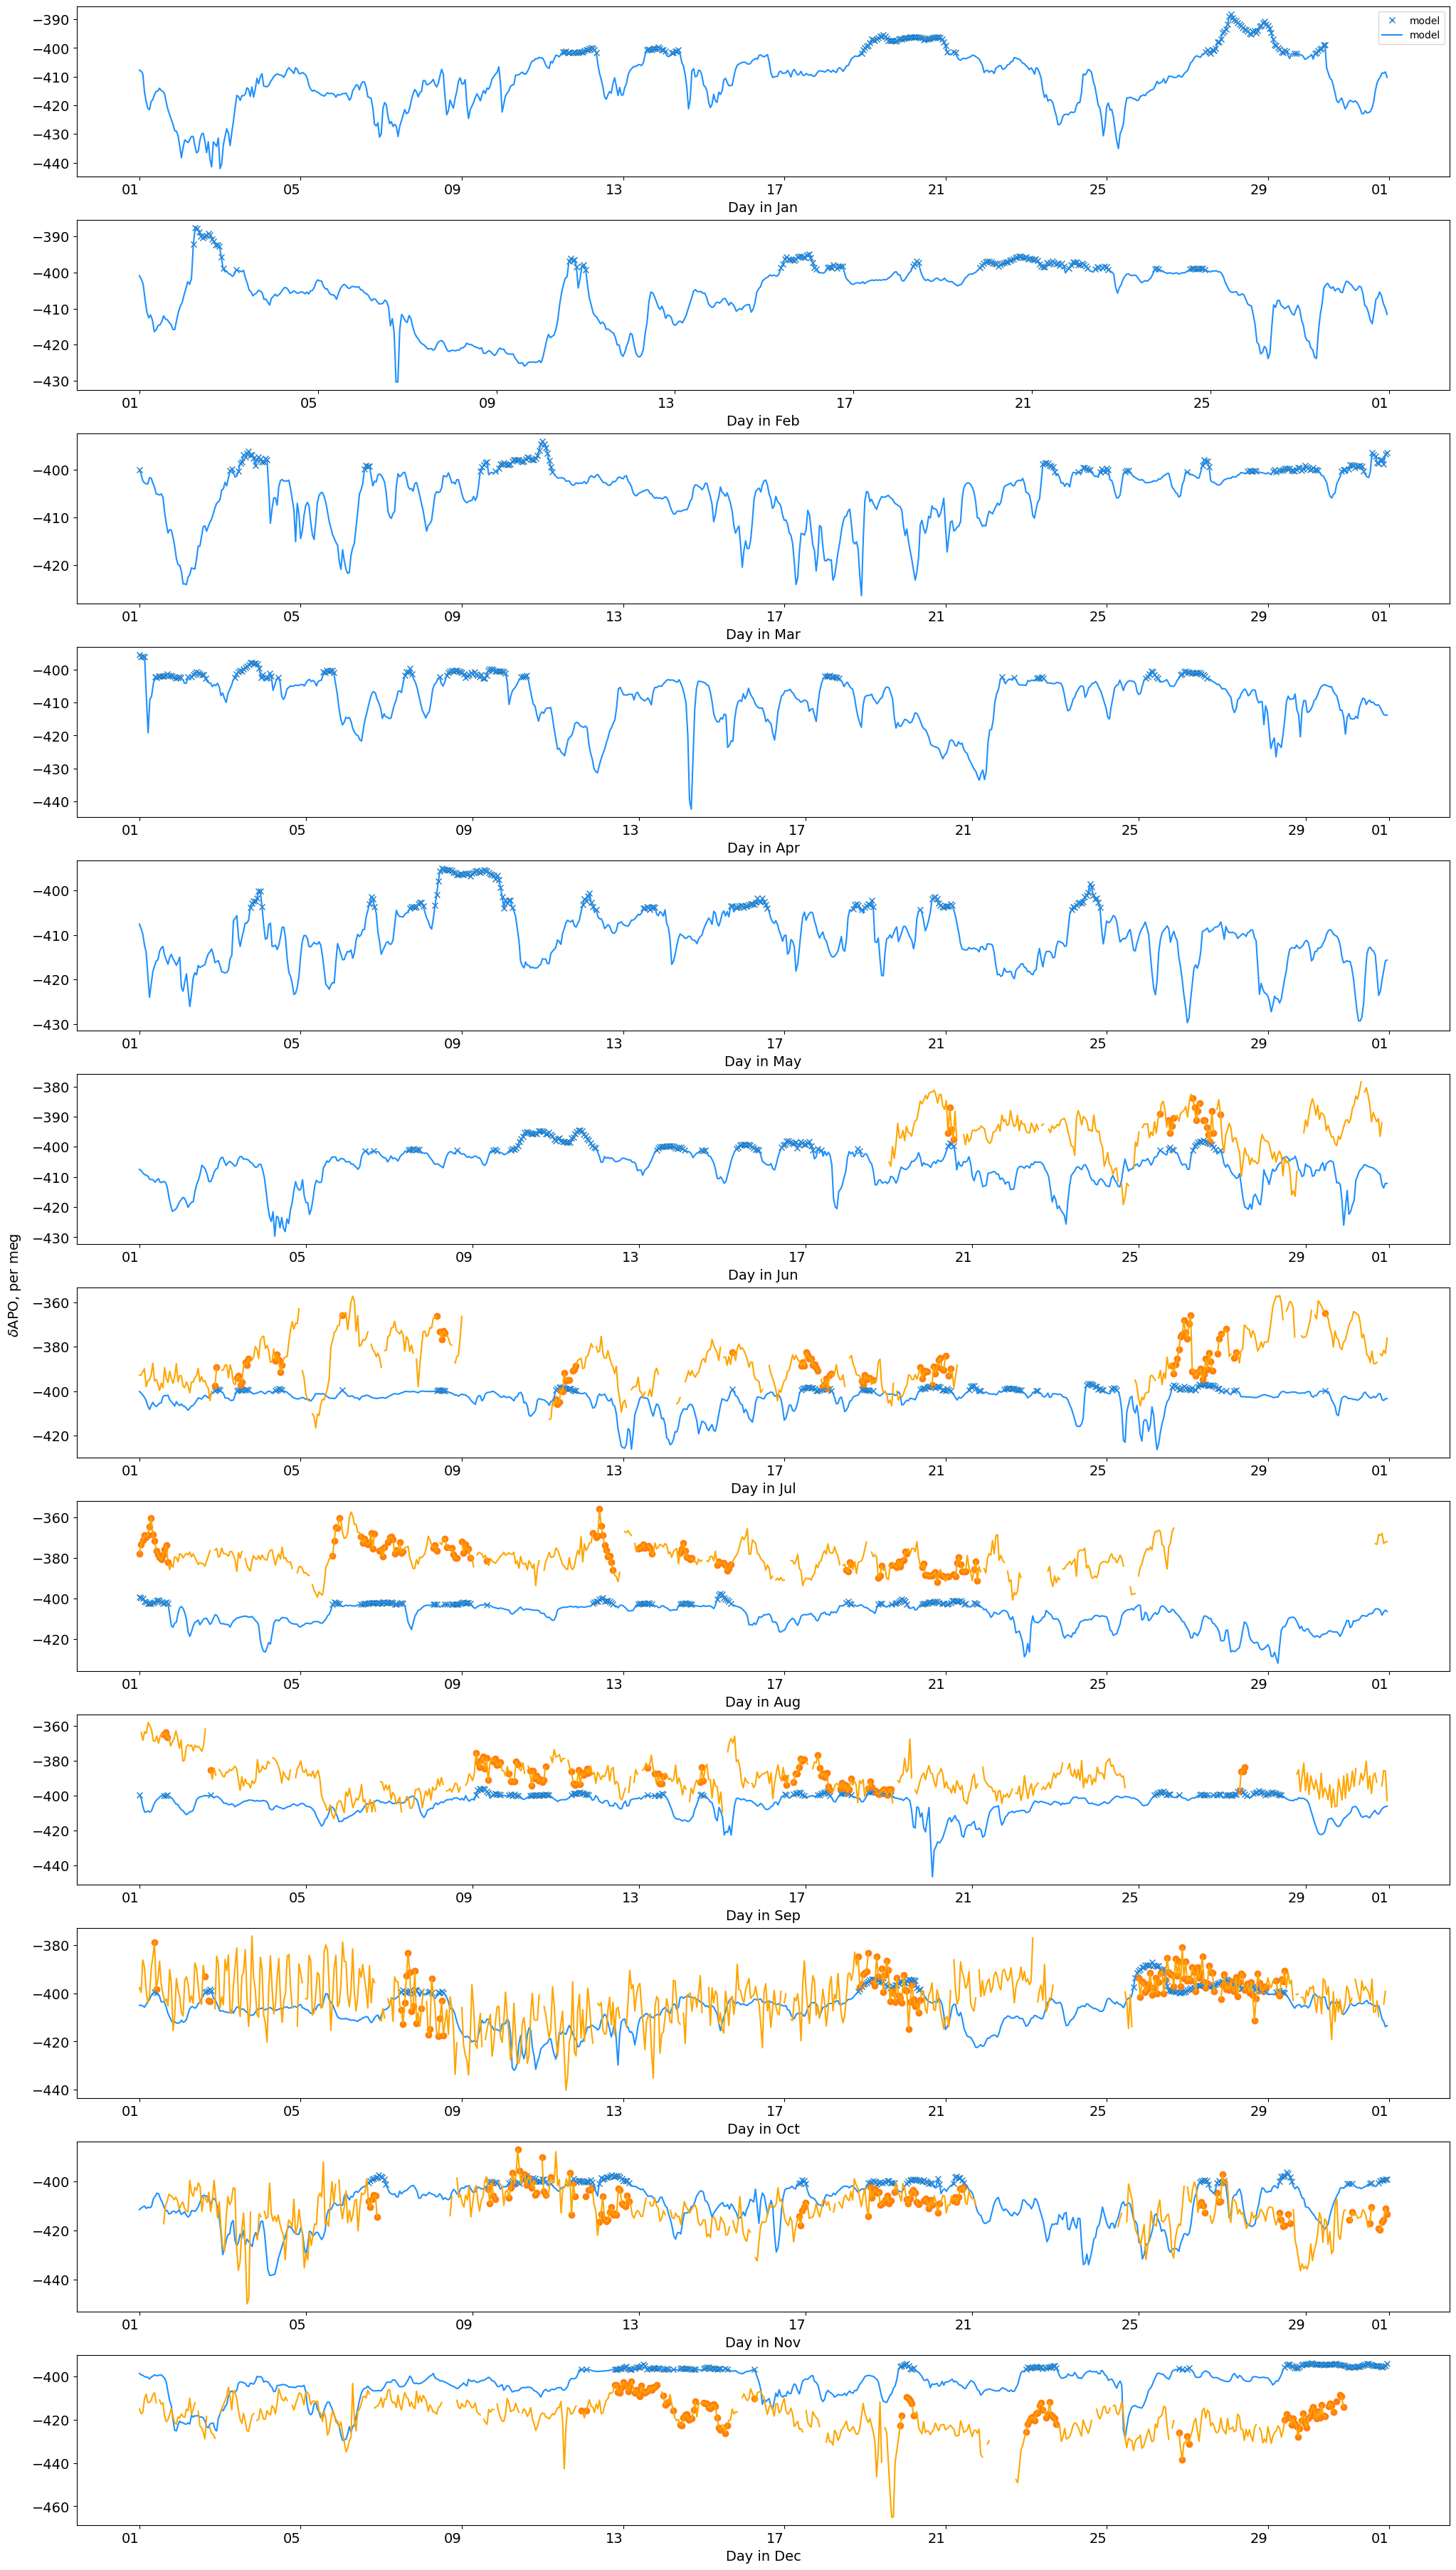

In [24]:
site = list(sites.keys())[1]

fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(20, 3*len(months)), constrained_layout=True)

[bkg_month.plot(ax=axes[mm], label='model', marker='x', ls='none')
 for mm, bkg_month in enumerate(model_bkg_points[site].values())]
[bkg_month.plot(ax=axes[mm], label='obs', marker='o', ls='none')
 for mm, bkg_month in enumerate(obs_bkg_points[site].values()) if bkg_month is not None]

[apo_month.plot(ax=axes[mm], label='model', color='dodgerblue')
 for mm, apo_month in enumerate(apo_model_no_ocean[site].values())]
[apo_month[site].mf.plot(ax=axes[mm], label='obs', color='orange')
 for mm, apo_month in enumerate(apo_obs.values()) if len(apo_month[site].mf.dropna(dim='time'))>0]

axes[0].legend()

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=14, labelrotation=0) for ax in axes]
# ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]

[axes[mm].set_xlabel(f'Day in {apo_plot_info.month_names[month]}', fontsize=14)
 for mm, month in enumerate(months)];
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=14)
else: ylabels = axes[0].set_ylabel(r'$\delta$APO, per meg', fontsize=14)

In [25]:
bkg_points_diff = {site: {month: mod_bkg_month - obs_bkg_points[site][month]
                                 if obs_bkg_points[site][month] is not None else [0]
                          for month, mod_bkg_month in mod_bkg_site.items()}
                   for site, mod_bkg_site in model_bkg_points.items()}
bkg_points_diff_ave = {site: {month: np.nanmedian(diff_month)
                              for month, diff_month in diff_site.items()}
                       for site, diff_site in bkg_points_diff.items()}

## Adjust the baseline

- subtract the difference from the APO model baseline,
- concatenate the months into a dataset for the year for each site.

In [27]:
bc_adj = {site: {month: ts_month.apo_bc - bkg_points_diff_ave[site][month]
                 for month, ts_month in ts_site.items()}
          for site, ts_site in ts_data_all.items()}

bc_adj_year = {site: xr.concat(bc_site.values(), dim='time')
               for site, bc_site in bc_adj.items()}

## Check the new baseline

- plot the adjusted and non-adjusted baseline for the whole year and the obs,
- remake a no-ocean APO model with the adjusted JC baseline,
- plot for each month to see how the model compares with the obs.

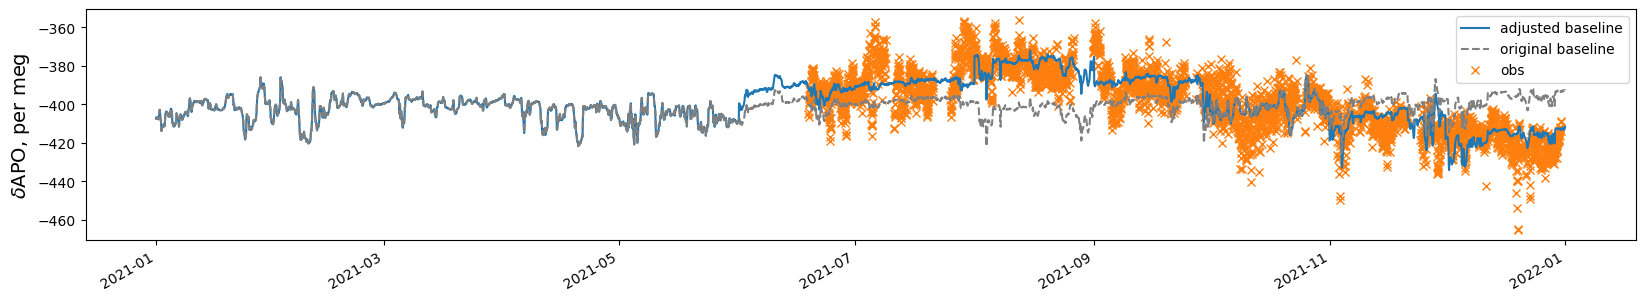

In [31]:
site = 'HFD'

fig, ax = plt.subplots(1, 1, figsize=(20, 3))

bc_adj_plot = bc_adj_year[site].plot(ax=ax, zorder=3, label='adjusted baseline')
bc_plot = ts_data_year[site].apo_bc.plot(ax=ax, zorder=4, ls='--', color='grey', label='original baseline')
obs_plot = apo_obs_year[site][0].mf.plot(ax=ax, marker='x', ls='none', label='obs')

ax.set_xlabel('');
ax.set_ylabel(r'$\delta$APO, per meg', fontsize=14);
legend = ax.legend()

In [33]:
apo_model_no_ocean_adj = {site: {month: apo_emiss_func.apo(ocean_co2 = xr.zeros_like(ts_month.o2_ocean_nemo),
                                                                                     ocean_n2 = xr.zeros_like(ts_month.o2_ocean_nemo),
                                                                                     ocean_o2 = xr.zeros_like(ts_month.o2_ocean_nemo),
                                                                                     ff_co2 = ts_month.co2_ff,
                                                                                     ff_o2 = ts_month.o2_ff) + bc_adj[site][month]
                             for month, ts_month in ts_site.items()}
                      for site, ts_site in ts_data_all.items()}

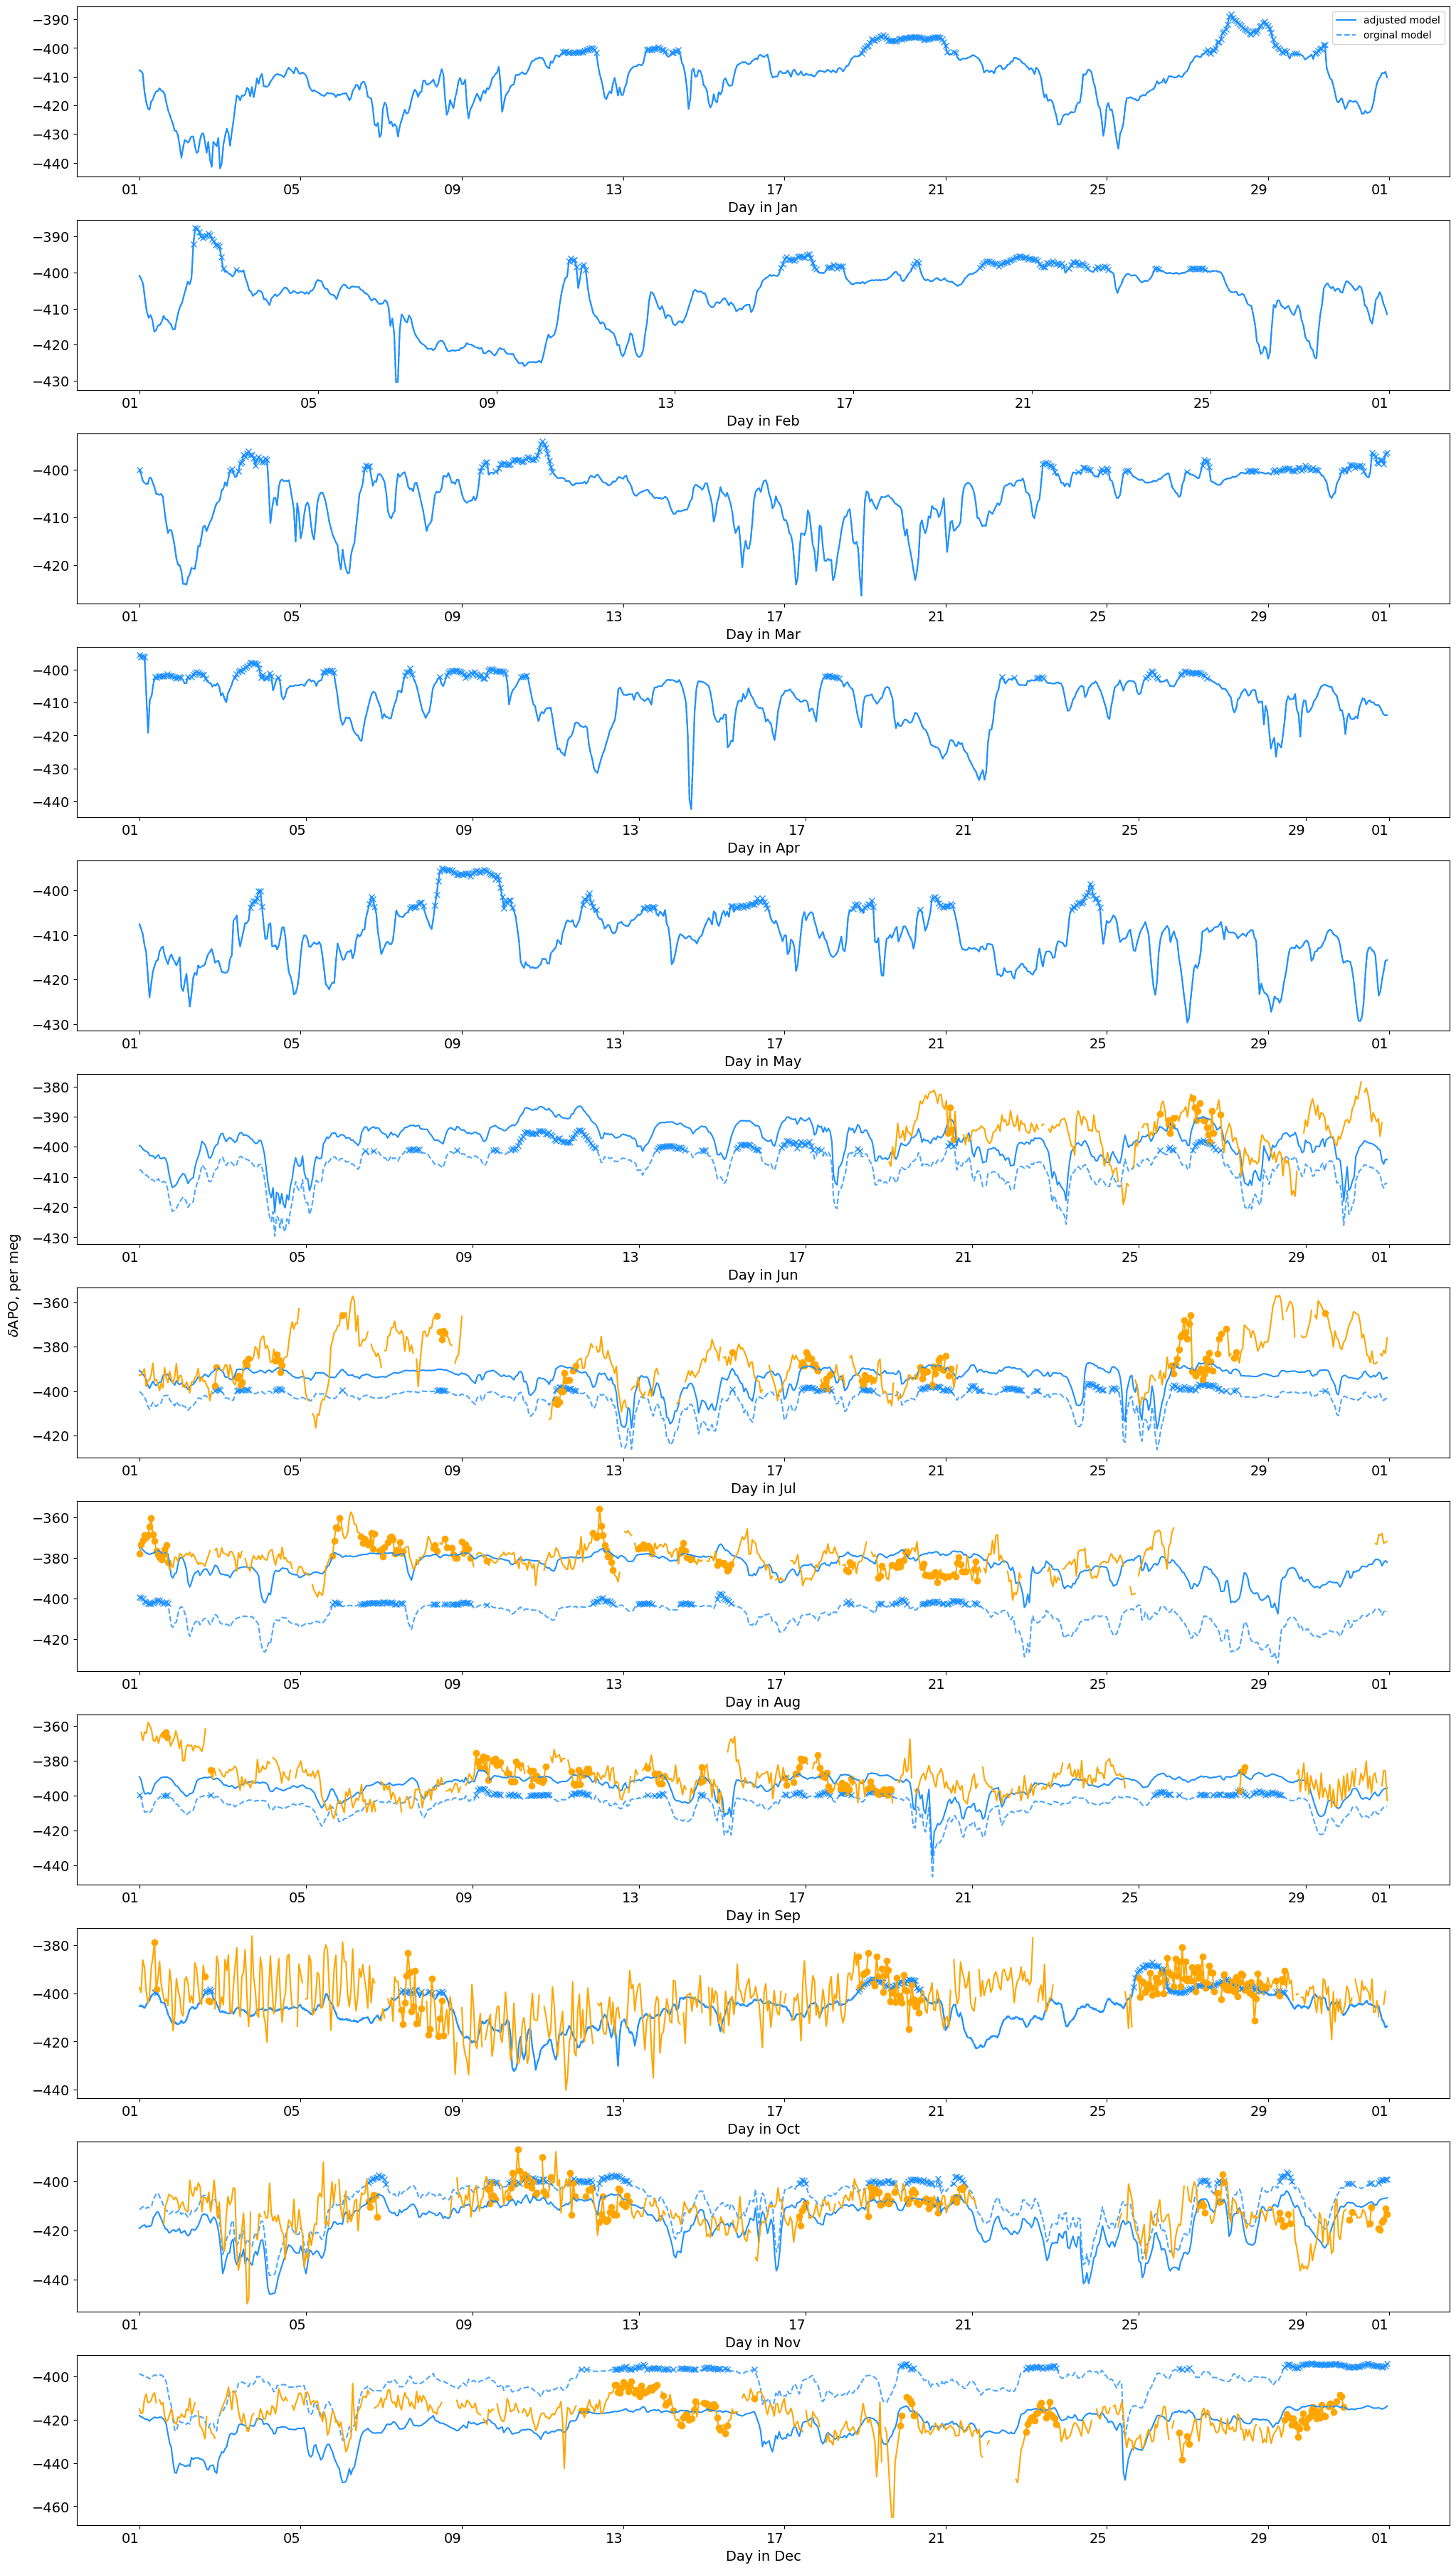

In [43]:
site = list(sites.keys())[1]

fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(20, 3*len(months)), constrained_layout=True)

[bkg_month.plot(ax=axes[mm], marker='x', ls='none', color='dodgerblue')
 for mm, bkg_month in enumerate(model_bkg_points[site].values())]
[bkg_month.plot(ax=axes[mm], marker='o', ls='none', color='orange')
 for mm, bkg_month in enumerate(obs_bkg_points[site].values()) if bkg_month is not None]

[apo_month.plot(ax=axes[mm], label='adjusted model', color='dodgerblue')
 for mm, apo_month in enumerate(apo_model_no_ocean_adj[site].values())]
[apo_month.plot(ax=axes[mm], label='orginal model', color='dodgerblue', ls='--', alpha=0.8)
 for mm, apo_month in enumerate(apo_model_no_ocean[site].values())]
[apo_month[site].mf.plot(ax=axes[mm], label='obs', color='orange')
 for mm, apo_month in enumerate(apo_obs.values()) if len(apo_month[site].mf.dropna(dim='time'))>0]

axes[0].legend()

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=14, labelrotation=0) for ax in axes]

[axes[mm].set_xlabel(f'Day in {apo_plot_info.month_names[month]}', fontsize=14)
 for mm, month in enumerate(months)];
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=14)
else: ylabels = axes[0].set_ylabel(r'$\delta$APO, per meg', fontsize=14)

## Save the new dataset

- open the original file containing the baselines,
- add the adjusted baseline array to the dataset,
- add the monthly adjustment to the attributes,
- save the dataset using the filename from the original file.

In [44]:
def include_bc_adj(dataset, adjusted_bc, adjustment):
    attributes = {'description': f'{dataset.apo.attrs["description"]}, with monthly adjustment',
                  'units': dataset.apo.attrs["units"],
                  'monthly_adjustment': str(adjustment)}
    dataset['apo_adjusted'] = adjusted_bc
    dataset['apo_adjusted'] = dataset['apo_adjusted'].assign_attrs(attributes)
    return dataset

filenames = {site: os.path.join('/user', 'work', 'vf20487', 'Timeseries', 'o2_co2',
                                f'{site}_bc_timeseries_{year}.nc')
             for site in sites}

bc_ds = {site: name.open_ds(filename) for site, filename in filenames.items()}

monthly_adjustment = {site: {month: round(adj_month, 4) for month, adj_month in adj_site.items()}
                      for site, adj_site in bkg_points_diff_ave.items()}
bc_ds = {site: include_bc_adj(bc_ds_site, bc_adj_year[site], adjustment=monthly_adjustment[site])
         for site, bc_ds_site in bc_ds.items()}

[print(f'Saving {site} adjusted apo baseline to file: {filename}')
 for site, filename in filenames.items()];
[bc_ds_site.to_netcdf(filenames[site]) for site, bc_ds_site in bc_ds.items()];

Saving WAO adjusted apo baseline to file: /user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2021.nc
Saving HFD adjusted apo baseline to file: /user/work/vf20487/Timeseries/o2_co2/HFD_bc_timeseries_2021.nc
